In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_hourly= pd.read_csv("../data/Processed/Solar_hourly_2021-2023.csv")

In [4]:
df_hourly["measured_on"]=pd.to_datetime(df_hourly["measured_on"])
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8830 entries, 0 to 8829
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   measured_on         8830 non-null   datetime64[ns, UTC]
 1   Power               8830 non-null   float64            
 2   Solar Zenith Angle  8830 non-null   float64            
 3   Aerosol_depth       8830 non-null   float64            
 4   Humidity            8830 non-null   float64            
 5   Surface Albedo      8830 non-null   float64            
 6   Wind Speed          8830 non-null   float64            
 7   Cloud Type          8830 non-null   float64            
 8   Pressure            8830 non-null   float64            
 9   Precipitable Water  8830 non-null   float64            
 10  Ozone               8830 non-null   float64            
 11  Temp                8830 non-null   float64            
 12  Avg_irradiance      8830 non-null 

In [5]:
unique_months = df_hourly['month'].unique()

In [6]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold



#array for holding validation scores.  First column will be for linear model, second for GAM.
rmse_scores = np.full((5, 1), np.nan)
r2_scores= np.full((5, 1), np.nan)



kf = KFold(n_splits=5, shuffle=True)
for i , (train_day_idx, test_day_idx) in enumerate(kf.split(unique_months)):
    train_days = unique_months[train_day_idx]
    test_days = unique_months[test_day_idx]
    train = df_hourly[df_hourly['month'].isin(train_days)]
    val= df_hourly[df_hourly['month'].isin(test_days)]
    train_X = train.iloc[:,[7,10,26,27,28,29.30,31,13,15,16,17,18,19,34,3,4,11]]
    val_X = val.iloc[:,[7,10,26,27,28,29.30,31,13,15,16,17,18,19,34,3,4,11]]
    train_y=train["Power"]
    val_y=val["Power"]
    
    
    from xgboost import XGBRegressor, XGBRFRegressor
    
    xgb_gb = XGBRegressor(
    enable_categorical=True,
    n_estimators=800,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=2.0,            # require loss reduction for splits
    reg_alpha=1.0,        # add L1 penalty
    reg_lambda=2.0,       # add L2 penalty
    random_state=42,
    early_stopping_rounds=25
)
    xgb_gb.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)
    xgb_gb_pred=xgb_gb.predict(val_X)
    
    
    rmse_scores[i,0]=root_mean_squared_error(val_y,xgb_gb_pred)
    r2_scores[i,0]=r2_score(val_y,xgb_gb_pred)
  


    

print(f'RMSEs on each fold: \n {np.round(rmse_scores,2)}')
print(f'Mean RMSE: {np.round(np.mean(rmse_scores, axis = 0),2)}')
print(f'Standard deviation: {np.round(np.std(rmse_scores, axis = 0),2)}')
print(f'r2 on each fold: \n {np.round(r2_scores,2)}')
print(f'Mean r2: {np.round(np.mean(r2_scores, axis = 0),2)}')

RMSEs on each fold: 
 [[554.06]
 [505.42]
 [470.22]
 [516.28]
 [492.62]]
Mean RMSE: [507.72]
Standard deviation: [27.79]
r2 on each fold: 
 [[0.8 ]
 [0.8 ]
 [0.86]
 [0.82]
 [0.82]]
Mean r2: [0.82]


/var/folders/f4/xfd055z54dzc8gv8yp56gc7h0000gn/T/ipykernel_13440/3498469779.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['date'] = val["measured_on"].dt.date
/var/folders/f4/xfd055z54dzc8gv8yp56gc7h0000gn/T/ipykernel_13440/3498469779.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Pred_Energy'] = xgb_gb_pred


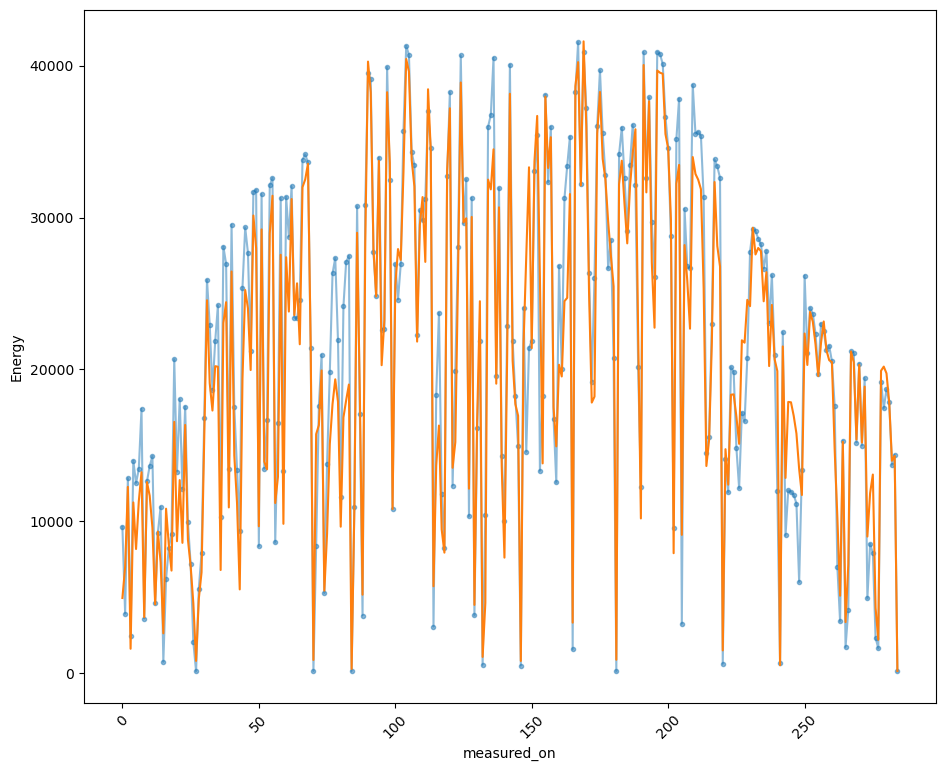

In [7]:

start_date = '2021-01-01'
end_date = '2022-12-31'
mask = (df_hourly['measured_on'] >= start_date) & (df_hourly['measured_on'] <= end_date)

train=df_hourly[mask]
mask_val=(df_hourly['measured_on'] >= '2023-01-01') & (df_hourly['measured_on'] <= '2023-12-31')
val=df_hourly[mask_val]

#train = train.set_index('measured_on')
#val = val.set_index('measured_on')


train_X = train.iloc[:,[7,10,26,27,28,29.30,31,13,15,16,17,18,19,34,3,4]]
val_X = val.iloc[:,[7,10,26,27,28,29.30,31,13,15,16,17,18,19,34,3,4]]
train_y=train["Power"]
val_y=val["Power"]


xgb_gb = XGBRegressor(
    enable_categorical=True,
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=2.0,            # require loss reduction for splits
    reg_alpha=1.0,        # add L1 penalty
    reg_lambda=2.0,       # add L2 penalty
    random_state=42,
    early_stopping_rounds=25
)
xgb_gb.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)

xgb_gb_pred=xgb_gb.predict(val_X)

val['date'] = val["measured_on"].dt.date
val['Pred_Energy'] = xgb_gb_pred
Energy = val.groupby('date')[['Power', 'Pred_Energy']].sum().reset_index()
Energy = Energy.rename(columns={'Power': 'Energy'})



axes= Energy['Energy'].plot(marker='.', alpha=0.5, figsize=(11, 9))
#axes= Energy['Pred_Energy'].plot(marker='o', alpha=0.5, figsize=(11, 9))
plt.plot(Energy.index, Energy['Pred_Energy'])

plt.xticks(rotation=45)    
plt.xlabel('measured_on')
plt.ylabel('Energy')
plt.show()
#Energy.head(5)